<a href="https://colab.research.google.com/github/KarelZe/thesis/blob/baseline/notebooks/3.0-mb-data_preprocessing_explanatory_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
!pip install gcsfs==2022.10.0
!pip install wandb==0.13.4
!pip install scikit-learn==1.1.3
!pip install SciencePlots==1.0.9
!pip install seaborn==0.12.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement scikit-learn==1.1.3 (from versions: 0.9, 0.10, 0.11, 0.12, 0.12.1, 0.13, 0.13.1, 0.14, 0.14.1, 0.15.0b1, 0.15.0b2, 0.15.0, 0.15.1, 0.15.2, 0.16b1, 0.16.0, 0.16.1, 0.17b1, 0.17, 0.17.1, 0.18, 0.18.1, 0.18.2, 0.19b2, 0.19.0, 0.19.1, 0.19.2, 0.20rc1, 0.20.0, 0.20.1, 0.20.2, 0.20.3, 0.20.4, 0.21rc2, 0.21.0, 0.21.1, 0.21.2, 0.21.3, 0.22rc2.post1, 0.22rc3, 0.22, 0.22.1, 0.22.2, 0.22.2.post1, 0.23.0rc1, 0.23.0, 0.23.1, 0.23.2, 0.24.dev0, 0.24.0rc1, 0.24.0, 0.24.1, 0.24.2, 1.0rc1, 1.0rc2, 1.0, 1.0.1, 1.0.2)
ERROR: No matching distribution found for scikit-learn==1.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/co

In [54]:
import os
import random

from catboost import CatBoostClassifier, Pool

import gcsfs
import google.auth
from google.colab import auth

import numpy as np
from numpy.testing import assert_almost_equal
import matplotlib.pyplot as plt
from pandas._testing.asserters import assert_almost_equal
import pandas as pd

import seaborn as sns

import wandb


In [55]:
# plt.style.use(['science','no-latex', 'nature'])
plt.style.use("seaborn")
ratio = (16,9)

In [56]:
# connect to weights and biases
# run = wandb.init(project="thesis", job_type="dataset-creation", entity="fbv")

# dataset = wandb.Artifact(name="train_val_test", type="preprocessed_data")


In [57]:
# connect to google cloud storage
auth.authenticate_user()
credentials, _ = google.auth.default()
fs = gcsfs.GCSFileSystem(project="thesis", token=credentials)
fs_prefix = "gs://"


In [58]:
# set fixed seed
def seed_everything(seed):
    """
    Seeds basic parameters for reproducibility of results.
    """
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)


seed = 42
seed_everything(seed)


In [59]:
# replace with sampled data set later
data = pd.read_parquet(
    f"gs://thesis-bucket-option-trade-classification/data/preprocessed/matched_ise_quotes_2017.parquet"
)

data = data.sample(frac=0.1, axis=0)

# Some statistics 🔭

In [60]:
data.head()

,UNDERLYING_SYMBOL,QUOTE_DATETIME,SEQUENCE_NUMBER,ROOT,EXPIRATION,STRK_PRC,OPTION_TYPE,TRADE_SIZE,TRADE_PRICE,BEST_BID,...,bid_ex,bid_size_ex,ask_size_ex,price_all_lead,price_all_lag,optionid,day_vol,price_ex_lead,price_ex_lag,buy_sell
47524347,C,2017-02-28 11:11:33,292794492,C,2017-03-03,58.0,P,28,0.06,0.05,...,0.05,66.0,28.0,0.070000,0.080000,114437584.0,502.0,0.070000,0.070000,1
48042233,GOOGL,2017-03-30 14:50:45,128433529,GOOGL,2017-05-19,860.0,C,13,19.83,19.60,...,19.10,17.0,2.0,19.660000,19.809999,114967192.0,50.0,19.660000,19.809999,1
47631819,SPY,2017-03-06 15:25:19,63814138,SPY,2017-05-19,185.0,P,10,0.15,0.14,...,0.14,32.0,418.0,0.160000,0.160000,114609392.0,20.0,0.110000,0.220000,1
47504802,GOOG,2017-02-27 12:29:24,178778352,GOOG,2017-03-17,770.0,C,2,59.18,57.50,...,57.50,7.0,12.0,62.700001,56.500000,112480184.0,2.0,62.700001,50.430000,1
47131114,EBAY,2017-02-07 09:30:00,134460304,EBAY,2017-02-17,28.0,P,1,0.20,0.00,...,0.00,0.0,53.0,0.010000,0.020000,113373136.0,1.0,NaN,0.020000,-1


In [61]:
data.describe()

,SEQUENCE_NUMBER,STRK_PRC,TRADE_SIZE,TRADE_PRICE,BEST_BID,BEST_ASK,order_id,ask_ex,bid_ex,bid_size_ex,ask_size_ex,price_all_lead,price_all_lag,optionid,day_vol,price_ex_lead,price_ex_lag,buy_sell
count,2.695410e+05,269541.000000,269541.000000,269541.000000,269541.000000,269541.000000,2.695410e+05,269287.000000,269287.000000,269287.000000,269287.000000,259827.000000,262942.000000,2.695060e+05,269541.000000,234455.000000,235410.000000,269541.000000
mean,9.670738e+07,188.432205,10.821816,5.176381,5.003937,5.351450,3.992828e+08,5.478387,4.924397,88.463806,94.585190,5.220384,5.134350,1.139758e+08,75.303009,5.330332,5.259740,-0.031183
std,1.527547e+08,599.141724,60.760224,19.876816,19.628731,20.127388,2.878051e+07,20.205841,19.563845,242.703705,237.956161,20.058762,19.564917,1.788720e+06,377.984985,20.503960,19.413485,0.999516
min,5.630000e+02,0.500000,1.000000,0.010000,0.000000,0.000000,3.483787e+08,0.000000,0.000000,0.000000,0.000000,0.010000,0.010000,1.052738e+08,1.000000,0.010000,0.010000,-1.000000
25%,3.073958e+07,35.000000,1.000000,0.330000,0.260000,0.390000,3.743133e+08,0.430000,0.220000,10.000000,12.000000,0.350000,0.350000,1.135523e+08,3.000000,0.350000,0.400000,-1.000000
50%,6.846554e+07,67.500000,3.000000,1.150000,1.060000,1.250000,4.000190e+08,1.340000,1.000000,25.000000,31.000000,1.180000,1.170000,1.144484e+08,10.000000,1.180000,1.250000,-1.000000
75%,1.102645e+08,127.000000,9.000000,3.460000,3.290000,3.650000,4.243273e+08,3.995000,3.200000,72.000000,82.000000,3.500000,3.450000,1.150770e+08,30.000000,3.510000,3.600000,1.000000
max,2.301185e+09,6325.000000,7500.000000,885.130005,882.000000,888.900024,4.475125e+08,890.000000,879.799988,9783.000000,7526.000000,964.799988,884.049988,1.285351e+08,15502.000000,871.969971,877.250000,1.000000


In [62]:
print(data.dtypes)

UNDERLYING_SYMBOL            object
QUOTE_DATETIME       datetime64[ns]
SEQUENCE_NUMBER               int64
ROOT                         object
EXPIRATION           datetime64[ns]
STRK_PRC                    float32
OPTION_TYPE                category
TRADE_SIZE                    int64
TRADE_PRICE                 float32
BEST_BID                    float32
BEST_ASK                    float32
order_id                      int64
ask_ex                      float32
bid_ex                      float32
bid_size_ex                 float32
ask_size_ex                 float32
price_all_lead              float32
price_all_lag               float32
optionid                    float32
day_vol                     float32
price_ex_lead               float32
price_ex_lag                float32
buy_sell                       int8
dtype: object


In [63]:
print(data.shape)

(269541, 23)


In [64]:
print(data.shape)
# drop identical rows, if present 
data.drop_duplicates(inplace=True)
print(data.shape)

(269541, 23)
(269541, 23)


In [140]:
data.head().T

,47524347,48042233,47631819,47504802,47131114
UNDERLYING_SYMBOL,C,GOOGL,SPY,GOOG,EBAY
QUOTE_DATETIME,2017-02-28 11:11:33,2017-03-30 14:50:45,2017-03-06 15:25:19,2017-02-27 12:29:24,2017-02-07 09:30:00
SEQUENCE_NUMBER,292794492,128433529,63814138,178778352,134460304
ROOT,C,GOOGL,SPY,GOOG,EBAY
EXPIRATION,2017-03-03 00:00:00,2017-05-19 00:00:00,2017-05-19 00:00:00,2017-03-17 00:00:00,2017-02-17 00:00:00
STRK_PRC,58.0,860.0,185.0,770.0,28.0
OPTION_TYPE,P,C,P,C,P
TRADE_SIZE,28,13,10,2,1
TRADE_PRICE,0.06,19.83,0.15,59.18,0.2
BEST_BID,0.05,19.6,0.14,57.5,0.0


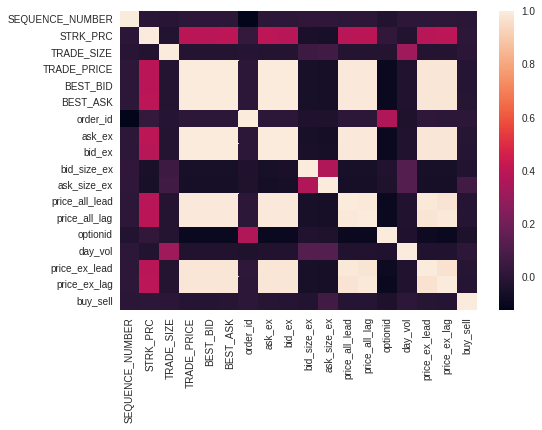

In [136]:
corr = data.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f76a3719890>]],
      dtype=object)

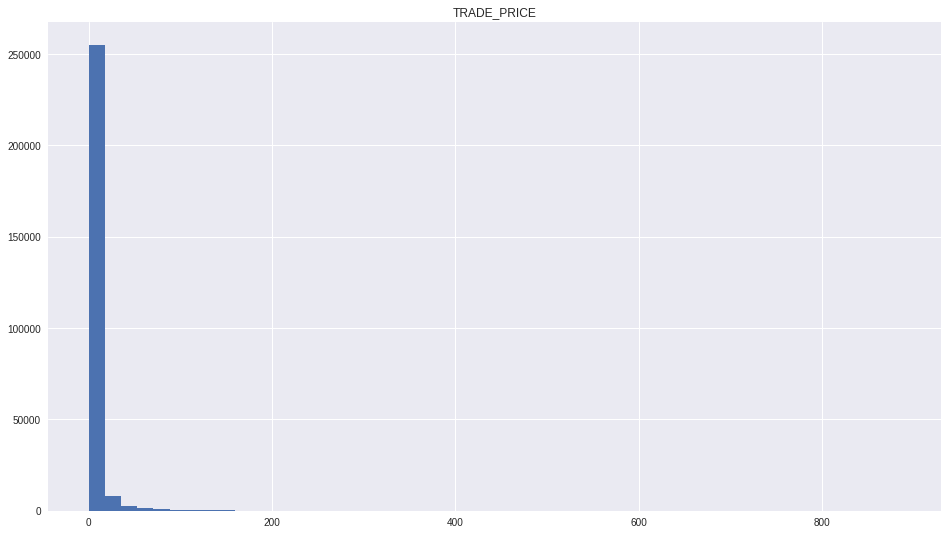

In [99]:
# FIXME: think about outliers
data[["TRADE_PRICE"]].hist(figsize=ratio, bins=50)

In [141]:
n = 10
data.nlargest(n, "TRADE_PRICE", keep='first').T

,47759812,48199450,47546715,47749577,48221226,48919416,48222637,47413723,47301753,47302059
UNDERLYING_SYMBOL,^NDX,^NDX,^NDX,PCLN,^NDX,^NDX,^NDX,PCLN,^NDX,^NDX
QUOTE_DATETIME,2017-03-14 14:33:10,2017-04-10 10:45:45,2017-03-01 10:51:45,2017-03-14 10:58:43,2017-04-11 10:31:04,2017-05-17 10:09:23,2017-04-11 10:44:04,2017-02-22 09:38:56,2017-02-15 10:58:13,2017-02-15 11:02:37
SEQUENCE_NUMBER,48145174,9999405,17072918,231677670,81904605,9049124,487358917,5487416,80043418,13354699
ROOT,NDX,NDX,NDX,PCLN,NDX,NDX,NDX,PCLN,NDX,NDX
EXPIRATION,2017-04-21 00:00:00,2017-05-19 00:00:00,2017-03-17 00:00:00,2019-01-18 00:00:00,2017-04-21 00:00:00,2017-06-30 00:00:00,2017-06-16 00:00:00,2018-01-19 00:00:00,2017-04-21 00:00:00,2017-03-17 00:00:00
STRK_PRC,4500.0,6300.0,4520.0,2600.0,4600.0,4900.0,4600.0,2400.0,4540.0,4540.0
OPTION_TYPE,C,P,C,P,C,C,C,P,C,C
TRADE_SIZE,1,1,1,1,1,1,1,1,1,1
TRADE_PRICE,885.130005,858.299988,847.599976,841.5,776.900024,772.599976,771.830017,756.299988,747.650024,739.940002
BEST_BID,882.0,854.400024,844.200012,841.5,771.599976,766.200012,767.5,751.299988,742.0,736.5


In [143]:
n = 10
data.nsmallest(n, "TRADE_PRICE", keep='first').T

,47820715,48140711,48843375,48111115,47621447,49091401,46721647,47764029,47827049,46607931
UNDERLYING_SYMBOL,XOM,DIS,GDX,TLT,TGT,MSFT,SPY,XRT,AAPL,CRM
QUOTE_DATETIME,2017-03-17 10:17:58,2017-04-05 15:23:20,2017-05-12 13:38:42,2017-04-04 13:15:04,2017-03-06 11:08:59,2017-05-24 15:59:32,2017-01-13 13:26:15,2017-03-14 15:48:35,2017-03-17 11:36:43,2017-01-06 14:46:12
SEQUENCE_NUMBER,20737251,65414054,66227457,39529800,51530653,110959280,88475354,109903579,96863608,256180842
ROOT,XOM,DIS,GDX,TLT,TGT,MSFT,SPY,XRT,AAPL,CRM
EXPIRATION,2017-03-24 00:00:00,2017-04-07 00:00:00,2017-05-12 00:00:00,2017-04-21 00:00:00,2017-04-07 00:00:00,2017-05-26 00:00:00,2017-01-18 00:00:00,2017-03-17 00:00:00,2017-03-17 00:00:00,2017-01-20 00:00:00
STRK_PRC,76.5,116.0,23.5,130.0,72.0,65.0,209.0,39.0,131.0,62.0
OPTION_TYPE,P,C,C,C,C,P,P,P,P,P
TRADE_SIZE,1,1,2,10,1,10,30,3,15,1
TRADE_PRICE,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
BEST_BID,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.01,0.0,0.01


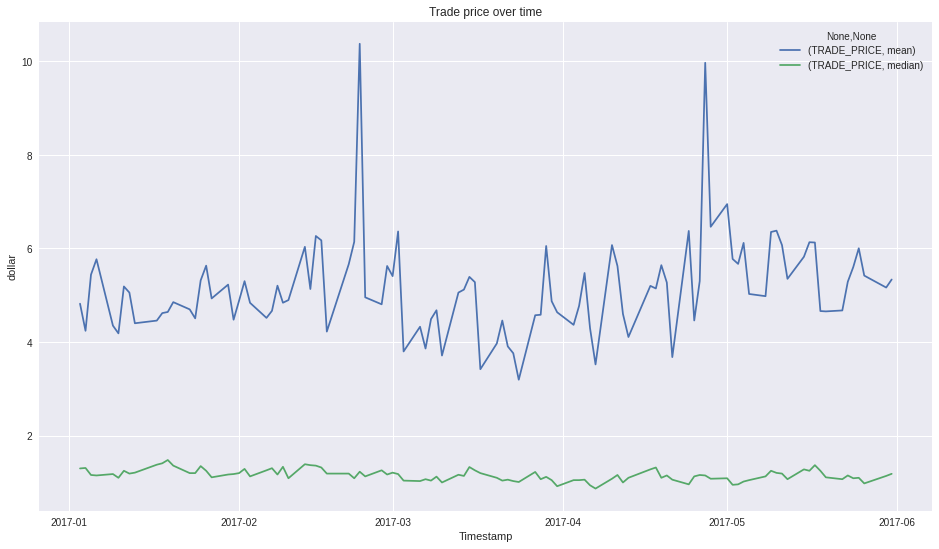

In [111]:
trades_over_time = data[["TRADE_PRICE"]].groupby(data['QUOTE_DATETIME'].dt.date).agg(['mean','median'])
trades_over_time.plot(kind="line", figsize=ratio, title="Trade price over time", xlabel="Timestamp", ylabel="dollar")

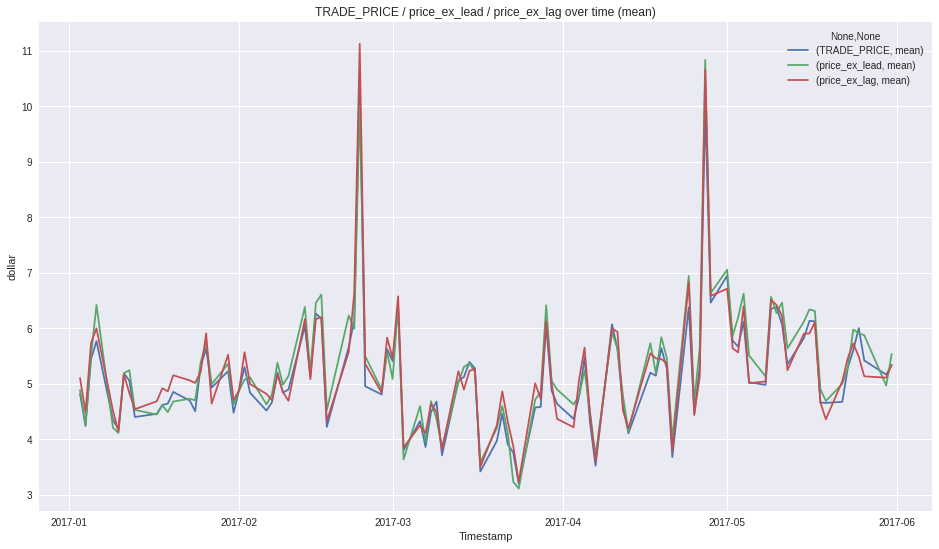

In [109]:
lead_lag_trade_price = data[["TRADE_PRICE", "price_ex_lead", "price_ex_lag"]].groupby(data['QUOTE_DATETIME'].dt.date).agg(['mean'])
lead_lag_trade_price.plot(kind="line", figsize=ratio, title="TRADE_PRICE / price_ex_lead / price_ex_lag over time (mean)", xlabel="Timestamp", ylabel="dollar")

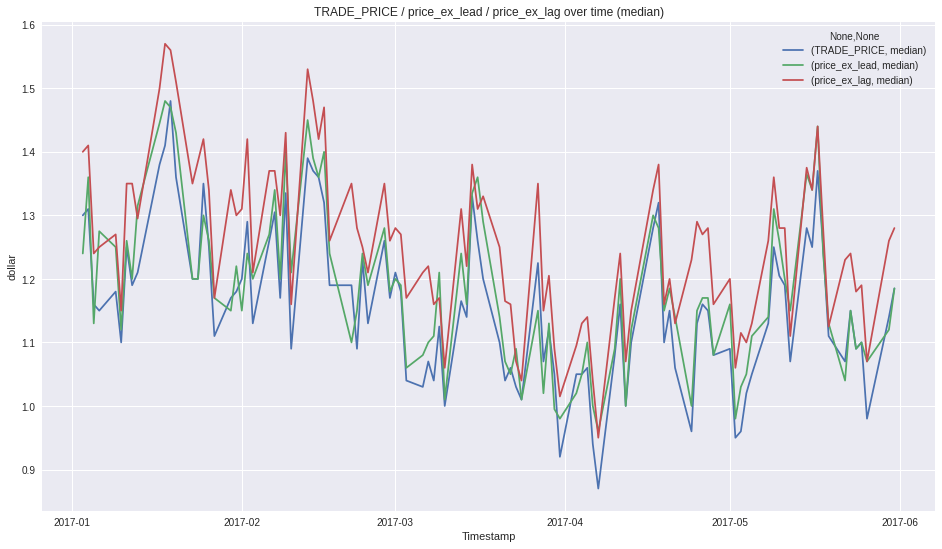

In [113]:
lead_lag_trade_price = data[["TRADE_PRICE", "price_ex_lead", "price_ex_lag"]].groupby(data['QUOTE_DATETIME'].dt.date).agg(['median'])
lead_lag_trade_price.plot(kind="line", figsize=ratio, title="TRADE_PRICE / price_ex_lead / price_ex_lag over time (median)", xlabel="Timestamp", ylabel="dollar")

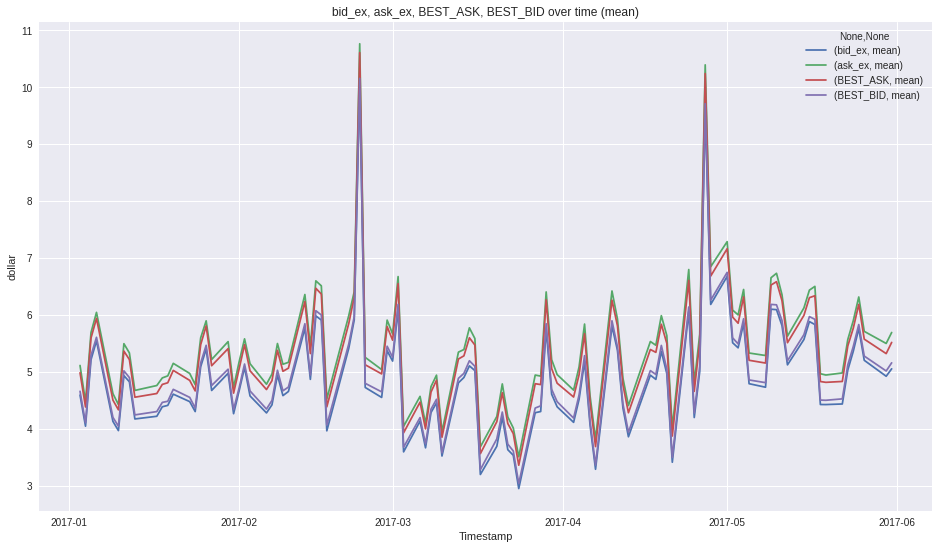

In [135]:
lead_lag_trade_price = data[["bid_ex", "ask_ex", "BEST_ASK", "BEST_BID"]].groupby(data['QUOTE_DATETIME'].dt.date).agg(['mean'])
lead_lag_trade_price.plot(kind="line", figsize=ratio, title="bid_ex, ask_ex, BEST_ASK, BEST_BID over time (mean)", xlabel="Timestamp", ylabel="dollar")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f76a3b6ae10>]],
      dtype=object)

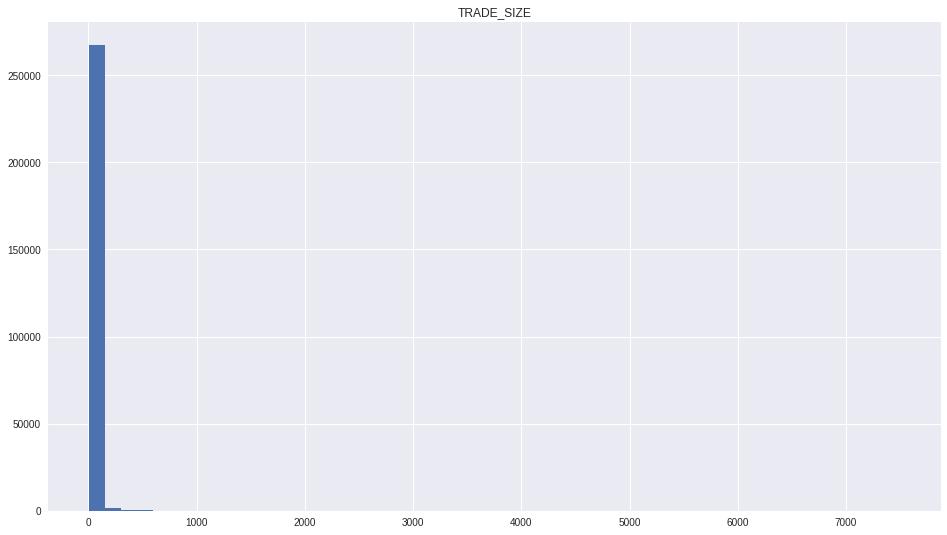

In [98]:
# Think about outliers
data[["TRADE_SIZE"]].hist(figsize=ratio, bins=50)

In [139]:
n = 10
data.nlargest(n, "TRADE_SIZE", keep='first').T

,47871794,48030719,46810316,48452080,46983138,48718977,47098190,48253066,47866449,47179034
UNDERLYING_SYMBOL,MBI,MBI,MYL,QQQ,EWZ,XOP,DSX,EEM,EEM,IWM
QUOTE_DATETIME,2017-03-21 10:54:45,2017-03-30 10:54:25,2017-01-19 15:34:08,2017-04-24 15:55:39,2017-01-27 15:55:54,2017-05-08 10:24:40,2017-02-03 14:09:51,2017-04-12 13:52:12,2017-03-21 09:39:42,2017-02-08 15:16:49
SEQUENCE_NUMBER,33461610,35343416,10570318,54190946,210917947,24104587,48553282,60252213,71723581,112280981
ROOT,MBI,MBI,MYL,QQQ,EWZ,XOP,DSX,EEM,EEM,IWM
EXPIRATION,2017-05-19 00:00:00,2017-05-19 00:00:00,2017-01-20 00:00:00,2017-05-19 00:00:00,2017-03-17 00:00:00,2017-06-02 00:00:00,2017-03-17 00:00:00,2017-05-12 00:00:00,2017-05-19 00:00:00,2017-02-17 00:00:00
STRK_PRC,8.0,8.0,45.0,128.5,42.0,32.0,3.0,39.0,34.5,124.0
OPTION_TYPE,P,P,P,P,C,P,P,P,P,P
TRADE_SIZE,7500,7500,6000,5123,5000,5000,4608,4418,4400,4064
TRADE_PRICE,0.46,0.31,8.04,0.25,0.28,0.21,0.13,0.67,0.1,0.06
BEST_BID,0.42,0.29,7.85,0.25,0.25,0.18,0.1,0.66,0.08,0.04


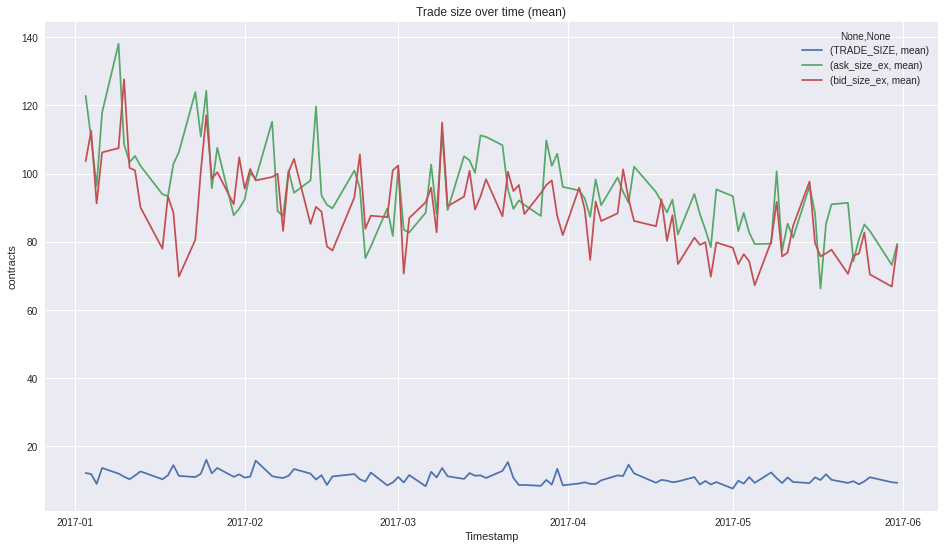

In [115]:
trades_over_time = data[["TRADE_SIZE", "ask_size_ex", "bid_size_ex"]].groupby(data['QUOTE_DATETIME'].dt.date).agg(['mean'])
trades_over_time.plot(kind="line", figsize=ratio, title="Trade size over time (mean)", xlabel="Timestamp", ylabel="contracts")

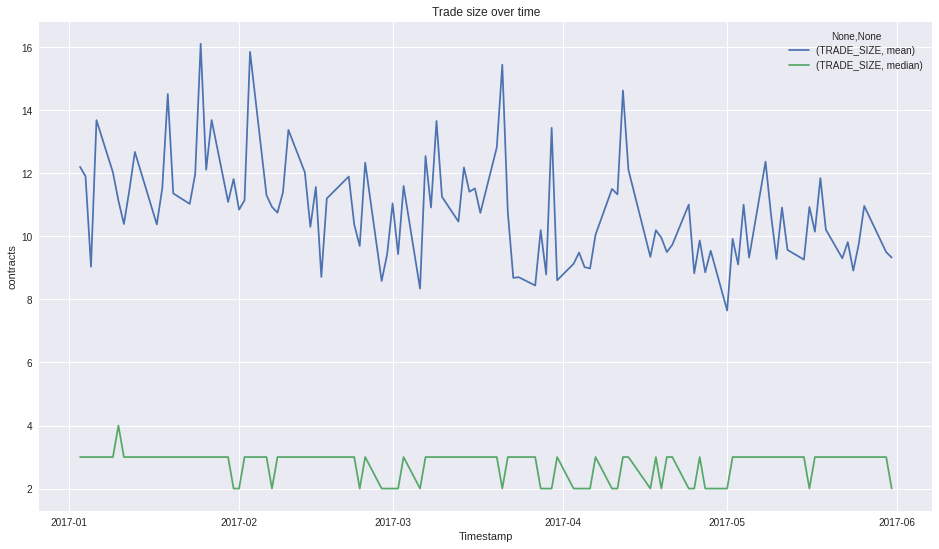

In [107]:
trades_over_time = data[["TRADE_SIZE"]].groupby(data['QUOTE_DATETIME'].dt.date).agg(['mean','median'])
trades_over_time.plot(kind="line", figsize=ratio, title="Trade size over time", xlabel="Timestamp", ylabel="contracts")

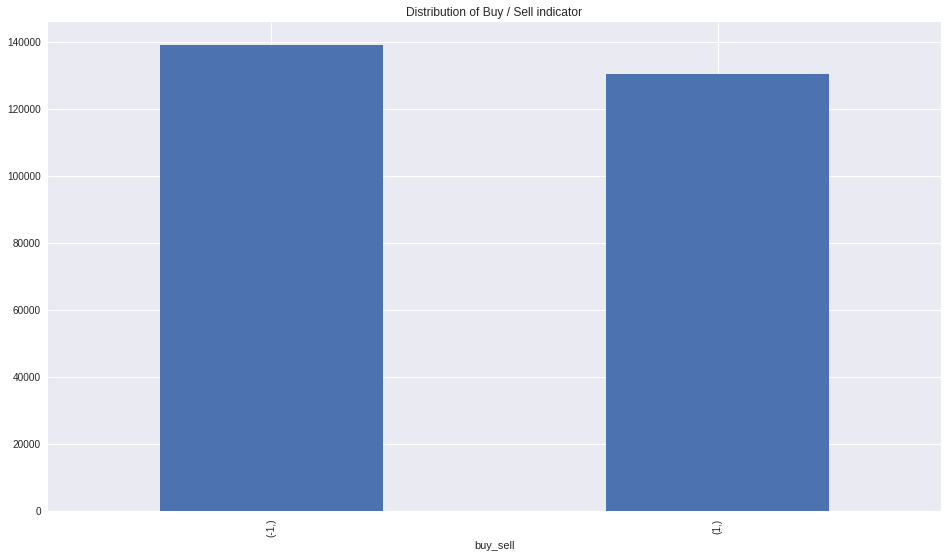

In [149]:
# FIXME: Fix xlabels
trades_over_time = data[["buy_sell"]].value_counts().plot(kind="bar", figsize=ratio, title="Distribution of Buy / Sell indicator")

In [155]:
trades_over_time = data[["buy_sell"]].value_counts()
trades_over_time = trades_over_time / trades_over_time.sum()

trades_over_time

buy_sell
-1          0.515591
 1          0.484409
dtype: float64

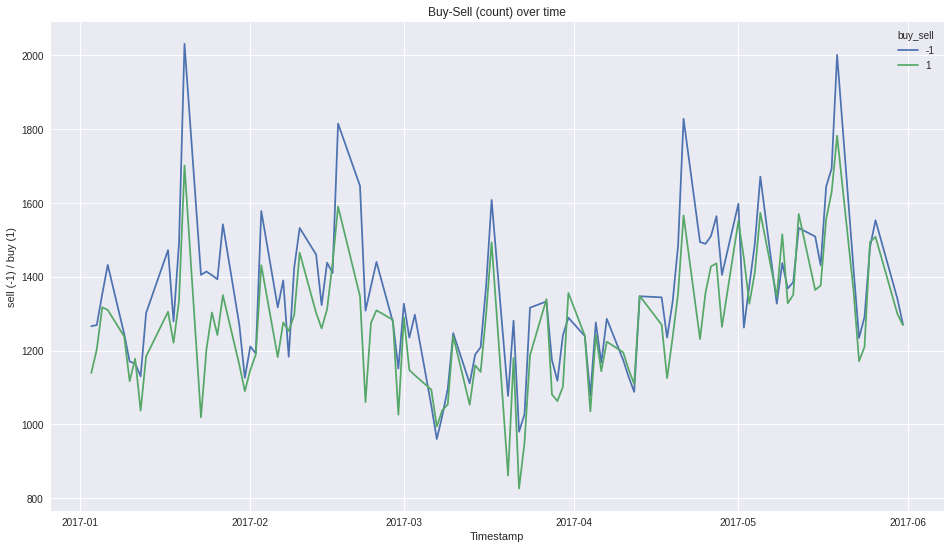

In [101]:
trades_over_time = data.groupby(data['QUOTE_DATETIME'].dt.date)["buy_sell"].value_counts().unstack(fill_value=0)
trades_over_time.plot(kind="line", figsize=ratio, title="Buy-Sell (count) over time", xlabel="Timestamp", ylabel="sell (-1) / buy (1)")

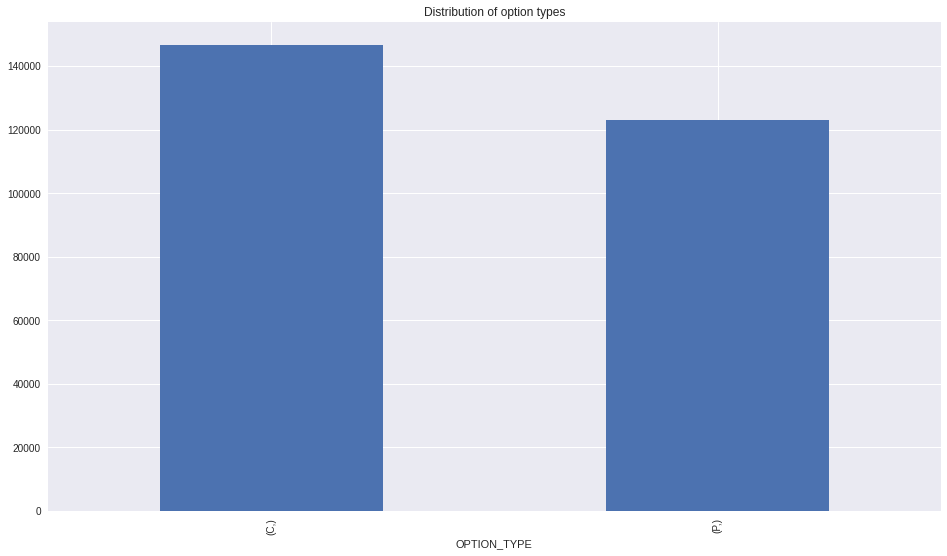

In [148]:
# FIXME: Fix labels
trades_over_time = data[["OPTION_TYPE"]].value_counts().plot(kind="bar", figsize=ratio, title="Distribution of option types")

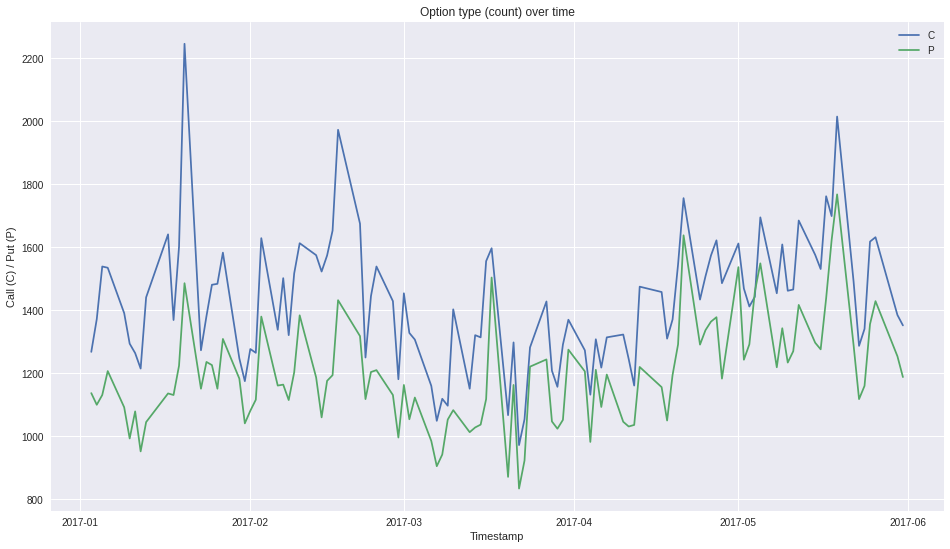

In [87]:
option_type_over_time = data.groupby(data['QUOTE_DATETIME'].dt.date)["OPTION_TYPE"].value_counts().unstack(fill_value=0)

option_type_over_time.plot(kind="line", figsize=ratio, title="Option type (count) over time", xlabel="Timestamp", ylabel="Call (C) / Put (P)")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f769055be10>]],
      dtype=object)

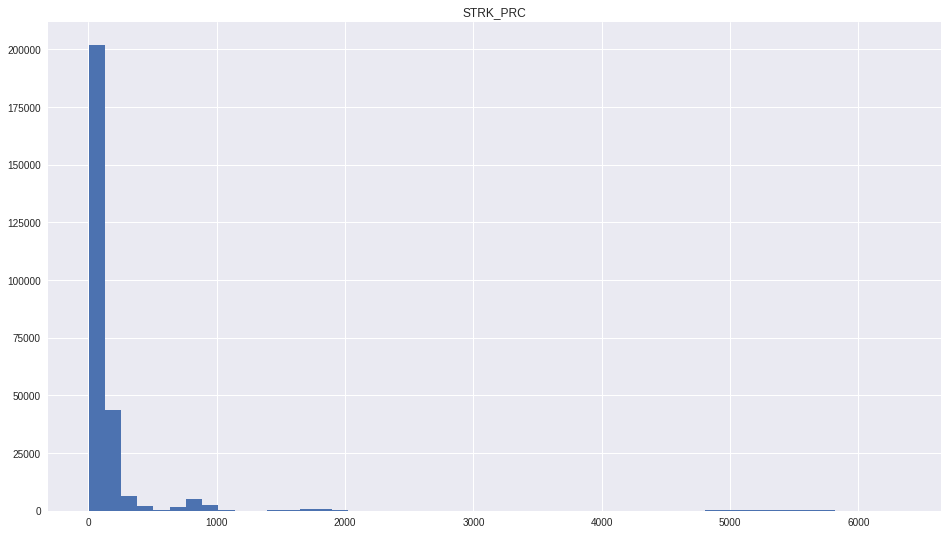

In [147]:
# FIXME: Think about outliers ->  transformation?
data[["STRK_PRC"]].hist(figsize=ratio, bins=50)

In [145]:
n = 10
data["ROOT"].value_counts()[:n].sort_values(ascending=False)

SPY     8461
AMZN    4747
IWM     3858
AAPL    3239
NDX     3189
TSLA    3125
SVXY    2930
FB      2864
QQQ     2835
TLT     2799
Name: ROOT, dtype: int64

## Visualize NaNs 🪲

In [65]:
def visualize_nan():
    """
    Visualize NaN values in a heatmap to learn about patterns.
    """
    plt.subplots(figsize=ratio)
    sns.heatmap(data.head(50).isnull(), cbar=False)
    plt.xlabel("feature")
    plt.ylabel("row")
    plt.title("Viz. of missing values (colored in bright beige)")
    plt.show()

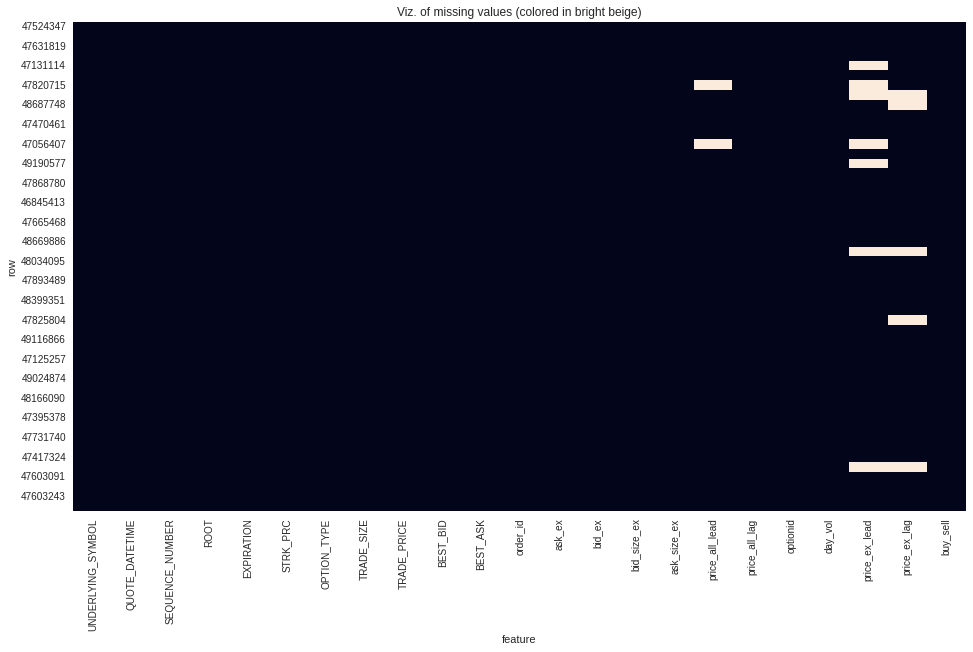

In [66]:
visualize_nan()

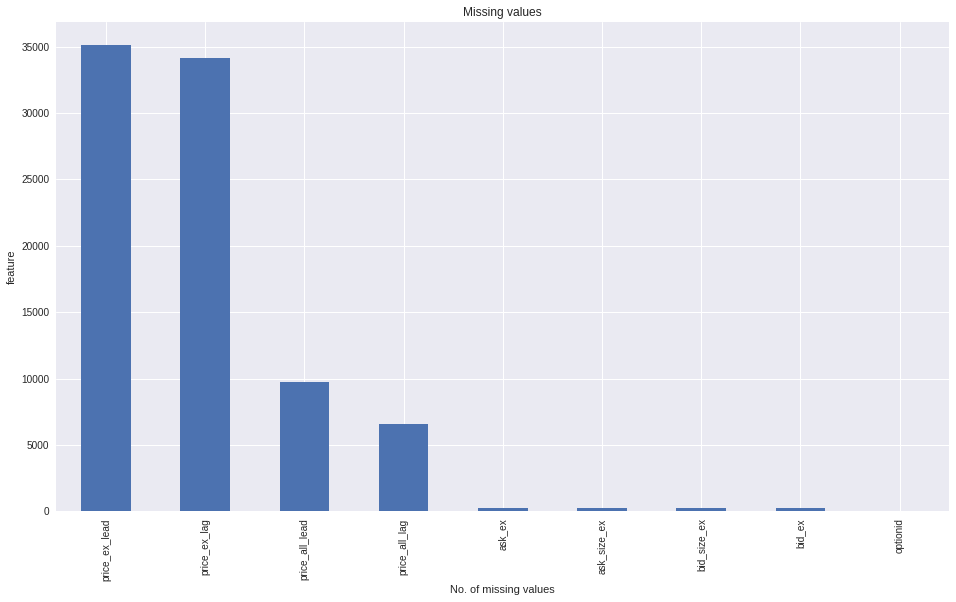

In [68]:
isna_vals = data.isna().sum().sort_values(ascending=False)
isna_vals = isna_vals.loc[lambda x: x > 0]

ax = isna_vals.T.plot(kind="bar", figsize=ratio, legend=False, 
                      xlabel="No. of missing values", 
                      ylabel="feature", 
                      title="Missing values")

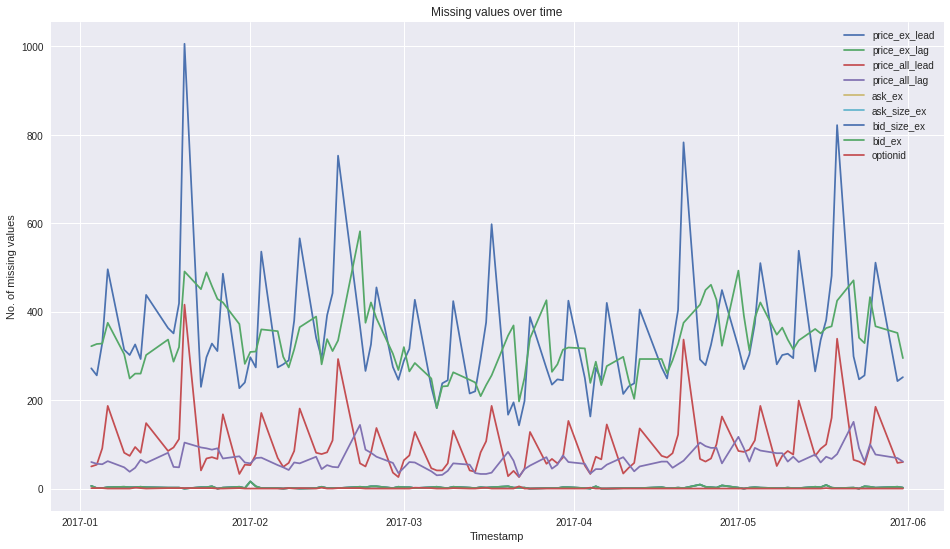

In [69]:
isna_vals_over_time = data[isna_vals.index.tolist()].groupby(data['QUOTE_DATETIME'].dt.date).agg(lambda x: x.isnull().sum())
isna_vals_over_time.plot(kind="line", figsize=ratio, title="Missing values over time", xlabel="Timestamp", ylabel="No. of missing values")

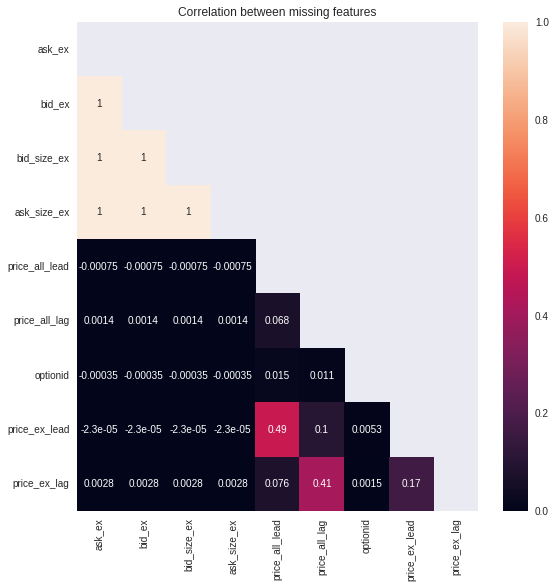

In [70]:
# adapted from: https://github.com/ResidentMario/missingno/blob/master/missingno/missingno.py

isna_data = data.iloc[:, [i for i, n in enumerate(np.var(data.isnull(), axis='rows')) if n > 0]]

corr_mat = isna_data.isnull().corr()
mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(9,9)) 
ax = sns.heatmap(corr_mat, mask=mask, annot=True, annot_kws={'size':10}, ax=ax)
ax.title.set_text("Correlation between missing features")

In [71]:
# ax = sample_firm_data['ret'].hist()
# ax.set_xlabel("return")
# ax.set_ylabel("freqency")
# ax.set_title(f"return distribution of permno: {sample_permno}")